In [3]:
import warnings
warnings.filterwarnings('ignore')


### Import Necessary Libraries

In [4]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import load_model
import h5py
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import librosa
import librosa.display
import tensorflow as tf
import IPython.display as ipd

### Preprocessing of Data 



In [15]:

# === Parameters ===
HDF5_PATH = 'bird_spectrograms.hdf5'
FIXED_SHAPE = (128, 517)  # (mel bins, time frames)

# === Step 1: Load the HDF5 spectrogram dataset ===
X_raw = []
y_raw = []

with h5py.File(HDF5_PATH, 'r') as f:
    for species in f.keys():
        for spec in f[species][:]:
            X_raw.append(spec)
            y_raw.append(species)

print(f"Total spectrograms loaded: {len(X_raw)}")

# === Step 2: Normalize each spectrogram (per sample) ===
def normalize(spec):
    return (spec - np.mean(spec)) / (np.std(spec) + 1e-6)

X_norm = [normalize(spec) for spec in X_raw]

# === Step 3: Pad/trim spectrograms to FIXED_SHAPE ===
def pad_or_trim(spec, target_shape=(128, 517)):
    padded = np.zeros(target_shape)
    h = min(spec.shape[0], target_shape[0])
    w = min(spec.shape[1], target_shape[1])
    padded[:h, :w] = spec[:h, :w]
    return padded

X_fixed = np.array([pad_or_trim(spec, FIXED_SHAPE) for spec in X_norm], dtype=np.float32)
X_fixed = np.expand_dims(X_fixed, axis=-1)  # For CNN input: (samples, height, width, 1)

# === Step 4: Encode species labels ===
le = LabelEncoder()
y_encoded = le.fit_transform(y_raw)
print("Encoded classes:", list(le.classes_))

# === Step 5: Stratified Split into Train, Val, Test ===
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_fixed, y_encoded):
    X_temp, X_test = X_fixed[train_idx], X_fixed[test_idx]
    y_temp, y_test = y_encoded[train_idx], y_encoded[test_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in sss2.split(X_temp, y_temp):
    X_train, X_val = X_temp[train_idx], X_temp[val_idx]
    y_train, y_val = y_temp[train_idx], y_temp[val_idx]

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# === Step 6: (Optional) Save preprocessed data ===
np.savez_compressed("preprocessed_birds.npz",
                    X_train=X_train, y_train=y_train,
                    X_val=X_val, y_val=y_val,
                    X_test=X_test, y_test=y_test,
                    class_names=le.classes_)
print("Preprocessed data saved as 'preprocessed_birds.npz'")


Total spectrograms loaded: 1536
Encoded classes: ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']
Train: 982, Val: 246, Test: 308
Preprocessed data saved as 'preprocessed_birds.npz'


### Check number of samples for each species

In [18]:

species_counts = {}

with h5py.File(HDF5_PATH, 'r') as f:
    for species in f.keys():
        count = f[species].shape[2]  # Each species is a dataset of spectrograms
        species_counts[species] = count


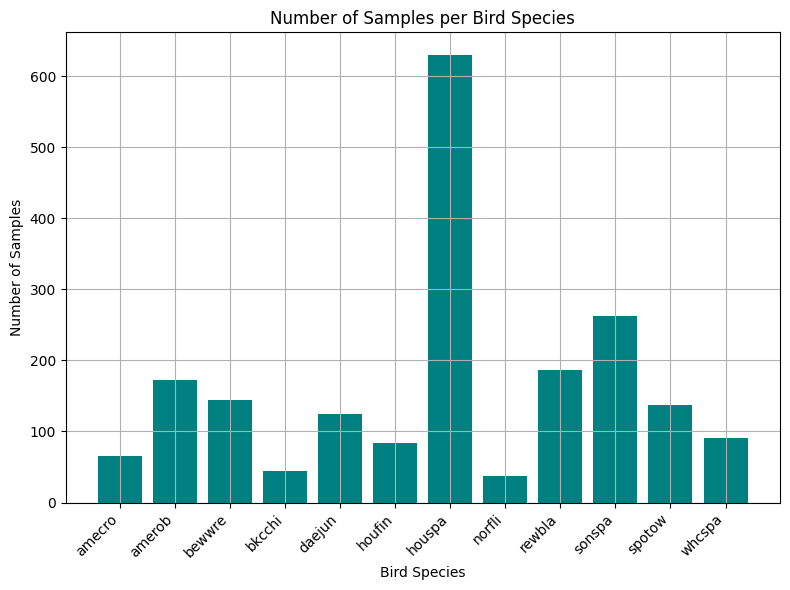

In [30]:
# Plot
plt.figure(figsize=(8, 6))
plt.bar(species_counts.keys(), species_counts.values(), color='teal')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.xlabel("Bird Species")
plt.ylabel("Number of Samples")
plt.title("Number of Samples per Bird Species")
plt.tight_layout()
plt.show()


### Training and Testing Split

In [20]:
# Load data
data = np.load("preprocessed_birds.npz")
X_train_all, y_train_all = data["X_train"], data["y_train"]
X_val_all, y_val_all = data["X_val"], data["y_val"]
X_test_all, y_test_all = data["X_test"], data["y_test"]
class_names = data["class_names"]

# Choose two classes
class_a = "houspa"
class_b = "sonspa"
class_a_idx = np.where(class_names == class_a)[0][0]
class_b_idx = np.where(class_names == class_b)[0][0]

def filter_binary(X, y, class0, class1):
    mask = np.isin(y, [class0, class1])
    X_bin = X[mask]
    y_bin = y[mask]
    y_bin = (y_bin == class1).astype(int)  # class1 = 1, class0 = 0
    return X_bin, y_bin

X_train, y_train = filter_binary(X_train_all, y_train_all, class_a_idx, class_b_idx)
X_val, y_val = filter_binary(X_val_all, y_val_all, class_a_idx, class_b_idx)
X_test, y_test = filter_binary(X_test_all, y_test_all, class_a_idx, class_b_idx)


#### Model Implementation

In [21]:

def build_binary_cnn(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(8, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
         layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = build_binary_cnn(X_train.shape[1:])

# Compute class weights (important for imbalance)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=32,
                    callbacks=[early_stop],
                    class_weight=class_weight_dict,
                    verbose=1)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 0.9642 - loss: 0.4865 - val_accuracy: 0.4878 - val_loss: 0.6528
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 1.0000 - loss: 0.3152 - val_accuracy: 0.4878 - val_loss: 0.6515
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 0.2233 - val_accuracy: 0.4878 - val_loss: 0.6480
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 1.0000 - loss: 0.1904 - val_accuracy: 0.4878 - val_loss: 0.6462
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 1.0000 - loss: 0.1423 - val_accuracy: 0.4878 - val_loss: 0.6457
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 1.0000 - loss: 0.0995 - val_accuracy: 0.4878 - val_loss: 0.6447
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 0.0908 - val_accuracy: 0.4878 - val_loss: 0.6237
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 0.0595 - val_accuracy: 0.4878 - val_loss:

### Accuracy and Loss Plots

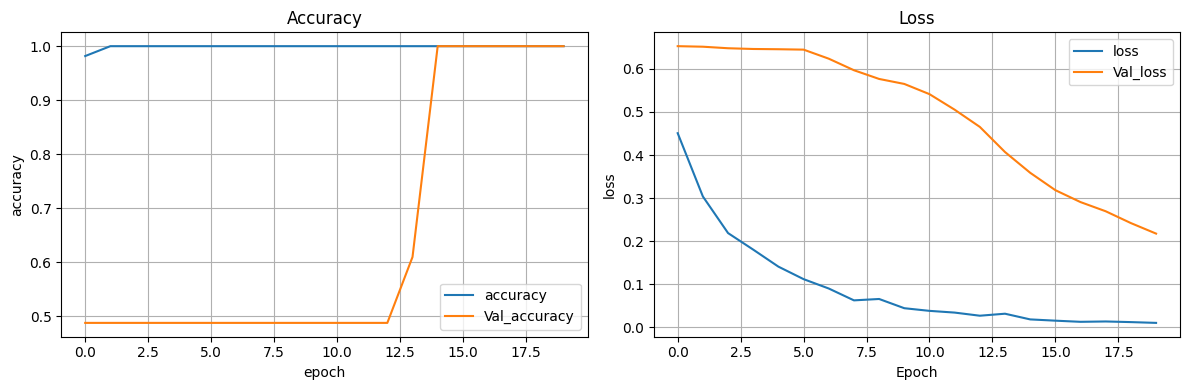

In [23]:
def plot_binary_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="Val_accuracy")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title("Accuracy")
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="Val_loss")
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_binary_history(history)



### Classification Report

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Classification Report:
              precision    recall  f1-score   support

      houspa       1.00      1.00      1.00        26
      sonspa       1.00      1.00      1.00        25

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



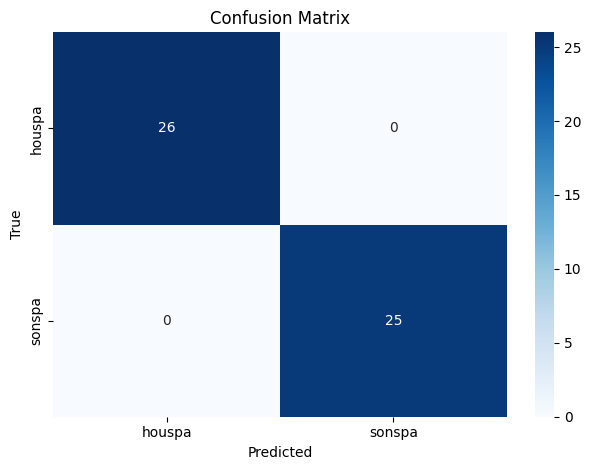

In [24]:
# Predict
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob >= 0.5).astype(int)

# Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[class_a, class_b]))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[class_a, class_b],
            yticklabels=[class_a, class_b])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


### Model Summary

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 515, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 257, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 255, 16)    │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 127, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 127, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 125, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,317 (83.27 KB)

 Trainable params: 7,073 (27.63 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 14,148 (55.27 KB)

### Save Model 

In [26]:
# Save model as a .h5 file
model.save("my_binary_cnn_model.h5")


### Load binary model 

In [27]:

# Load binary CNN model
binary_model = load_model("results/model/my_binary_cnn_model.h5")

# Use binary class names (must match training order)
binary_class_names = ['sonspa', 'houspa']  # Adjust if needed


### We have checked the binary model prediction on external test clips.

In [28]:

def predict_and_display(file_path, model, class_names, input_shape=(128, 517)):
    # === 1. Load the full audio ===
    y, sr = librosa.load(file_path, sr=22050)
    duration = librosa.get_duration(y=y, sr=sr)
    print(f"\n Analyzing: {file_path} — Duration: {duration:.2f}s")
    ipd.display(ipd.Audio(y, rate=sr))

    # === 2. Convert to mel spectrogram ===
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=input_shape[0])
    S_dB = librosa.power_to_db(S, ref=np.max)

    # === 3. Normalize and pad/truncate ===
    S_norm = (S_dB - np.mean(S_dB)) / (np.std(S_dB) + 1e-6)
    padded = np.zeros(input_shape)
    w = min(S_norm.shape[1], input_shape[1])
    padded[:, :w] = S_norm[:, :w]

    X_input = padded[np.newaxis, ..., np.newaxis]

    # === 4. Predict with the CNN ===
    pred = model.predict(X_input)[0]
    prob = float(pred)  # sigmoid output, scalar
    predicted_label = class_names[1] if prob > 0.5 else class_names[0]
    confidence = prob if prob > 0.5 else 1 - prob

    print(f" Predicted: {predicted_label} — Confidence: {confidence:.2%}")
    print(f"Class probabilities:")
    print(f"  {class_names[0]}: {1 - prob:.4f}")
    print(f"  {class_names[1]}: {prob:.4f}")

    # === 5. Plot spectrogram ===
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel Spectrogram (dB)")
    plt.tight_layout()
    plt.show()



 Analyzing: test1.mp3 — Duration: 23.28s


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
 Predicted: sonspa — Confidence: 52.20%
Class probabilities:
  sonspa: 0.5220
  houspa: 0.4780


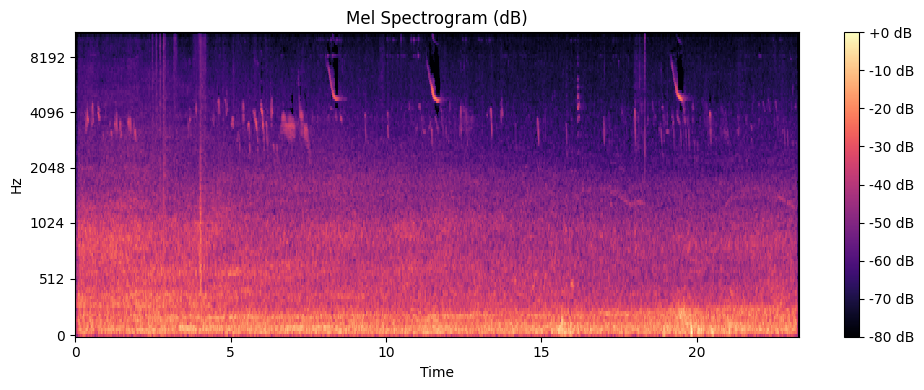


 Analyzing: test2.mp3 — Duration: 5.25s


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
 Predicted: sonspa — Confidence: 89.91%
Class probabilities:
  sonspa: 0.8991
  houspa: 0.1009


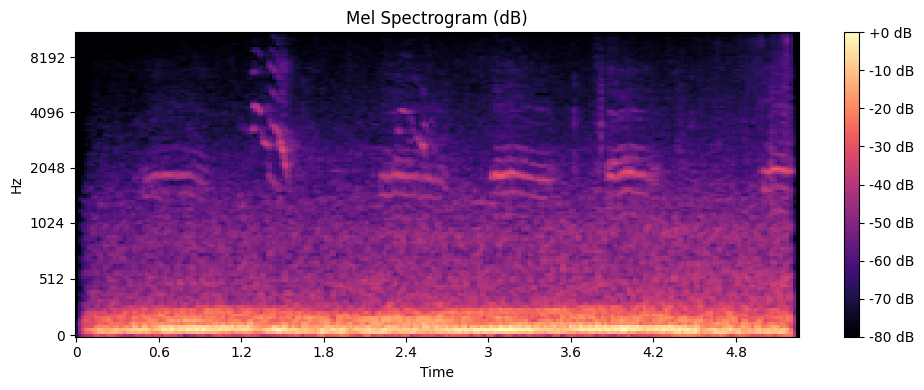


 Analyzing: test3.mp3 — Duration: 15.88s


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
 Predicted: houspa — Confidence: 55.45%
Class probabilities:
  sonspa: 0.4455
  houspa: 0.5545


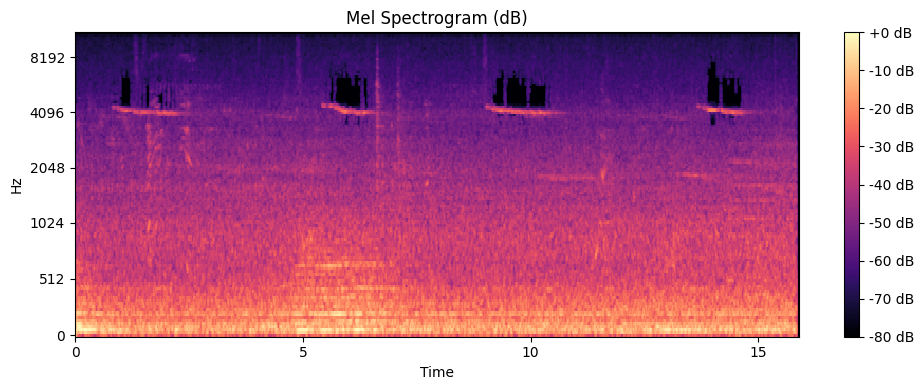

In [29]:
predict_and_display("test1.mp3", binary_model, binary_class_names)
predict_and_display("test2.mp3", binary_model, binary_class_names)
predict_and_display("test3.mp3", binary_model, binary_class_names)



### Interpretation


To evaluate generalization, we tested the binary CNN model on 3 real-world .mp3 clips. Unlike in-dataset test accuracy, the model showed more uncertainty in predictions (confidence ranging from ~52% to ~90%), indicating generalization beyond memorized samples.”